In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/20.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/6.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/5.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/8.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/30.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/38.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/33.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/10.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/35.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/9.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/37.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/1.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/29.jpg
/kaggle/input/cotton-leaf-disease-dataset/test/Powdery Mildew/16.jpg
/kaggle/input/cotton-leaf-disease-datas

Step 1: Import Required Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC


Step 2: Load and Augment Dataset

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = "/kaggle/input/cotton-leaf-disease-dataset/train"
test_dir = "/kaggle/input/cotton-leaf-disease-dataset/test"

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    zoom_range=0.3
)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=True
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False
)


Found 2400 images belonging to 6 classes.
Found 237 images belonging to 6 classes.


Step 3: Define Feature Extraction Function

In [4]:
def extract_features(generator, model, num_images):
    features, labels = [], []
    for images, lbls in generator:
        batch_features = model.predict(images)
        features.extend(batch_features)
        labels.extend(lbls)
        if len(features) >= num_images:
            break
    return np.array(features[:num_images]), np.array(labels[:num_images], dtype=int)


Step 4: Load Pre-Trained Feature Extractors

In [5]:
base_model1 = InceptionResNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
base_model2 = EfficientNetB3(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))

feature_extractor1 = Model(inputs=base_model1.input, outputs=base_model1.output)
feature_extractor2 = Model(inputs=base_model2.input, outputs=base_model2.output)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Step 5: Extract Features and Concatenate

In [6]:
X_train_features1, y_train_labels = extract_features(train_generator, feature_extractor1, train_generator.samples)
X_train_features2, _ = extract_features(train_generator, feature_extractor2, train_generator.samples)
X_test_features1, y_test_labels = extract_features(test_generator, feature_extractor1, 237)
X_test_features2, _ = extract_features(test_generator, feature_extractor2, 237)

X_train_features = np.concatenate([X_train_features1, X_train_features2], axis=1)
X_test_features = np.concatenate([X_test_features1, X_test_features2], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

Step 6: Apply SMOTE and Split Data

In [7]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_features, y_train_labels)

x_train, x_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [8]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", X_test_features.shape)

Shape of x_train: (1920, 3072)
Shape of y_train: (1920,)
Shape of x_val: (480, 3072)
Shape of y_val: (480,)
Shape of x_test: (237, 3072)


In [9]:
print(x_train.shape)  # Check shape before passing to the model

(1920, 3072)


In [10]:
from tensorflow.keras.utils import to_categorical

num_classes = 6  # Adjust based on dataset

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test_labels, num_classes=num_classes)  # Ensure test labels match

Step 7: Define Focal Loss Function

In [11]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')  # Ensure y_true is float
        y_pred = K.clip(y_pred, 1e-8, 1.0 - 1e-8)  # Prevent log(0)

        # Compute focal loss
        focal_weight = alpha * K.pow(1 - y_pred, gamma)
        loss = -focal_weight * y_true * K.log(y_pred)

        return K.mean(loss)
    return loss


Step 8: Optimize Hyperparameters using Genetic Algorithm

In [12]:
# Improve Meta-Heuristic Optimization
class GeneticAlgorithm:
    def __init__(self, population_size=20, generations=15):  # Increased size & depth
        self.population_size = population_size
        self.generations = generations
        self.population = [{'learning_rate': random.uniform(0.00005, 0.003),
                            'units': random.randint(128, 512),
                            'dropout': random.uniform(0.2, 0.5)} for _ in range(population_size)]

    def evaluate(self, params):
        model = Sequential([
            tf.keras.layers.Input(shape=(3072,)),  # Fix input layer
            Dense(int(params['units']), activation='relu'),
            BatchNormalization(),
            Dropout(params['dropout']),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(6, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                      loss=focal_loss(),  # Using Focal Loss
                      metrics=['accuracy'])
        history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0)
        return history.history.get('val_accuracy', [0.0])[-1]

    def optimize(self):
        for _ in range(self.generations):
            scores = [(self.evaluate(ind), ind) for ind in self.population]
            scores.sort(reverse=True, key=lambda x: x[0])
            self.population = [ind for _, ind in scores[:self.population_size // 2]]
        return self.population[0]


Step 9: Train Final Model with Best Hyperparameters

Step 10: Plot Performance Graphs

In [ ]:
train_precision = history.history.get('precision') or history.history.get('precision_1')
val_precision = history.history.get('val_precision') or history.history.get('val_precision_1')
train_recall = history.history.get('recall') or history.history.get('recall_1')
val_recall = history.history.get('val_recall') or history.history.get('val_recall_1')

train_f1 = [2 * (p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(train_precision, train_recall)]
val_f1 = [2 * (p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(val_precision, val_recall)]


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_precision, label='Training Precision')
plt.plot(epochs, val_precision, label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_recall, label='Training Recall')
plt.plot(epochs, val_recall, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_f1, label='Training F1-Score')
plt.plot(epochs, val_f1, label='Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1-Score')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['auc'], label='Training AUC')
plt.plot(epochs, history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC (ROC Curve)')
plt.legend()
plt.show()

Step 11: Plot Confusion Matrix

In [ ]:
y_pred = np.argmax(final_model.predict(X_test_features), axis=1)
conf_matrix = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Step 12: Print Classification Report

In [ ]:
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))


Found 2400 images belonging to 6 classes.
Found 237 images belonging to 6 classes.
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━

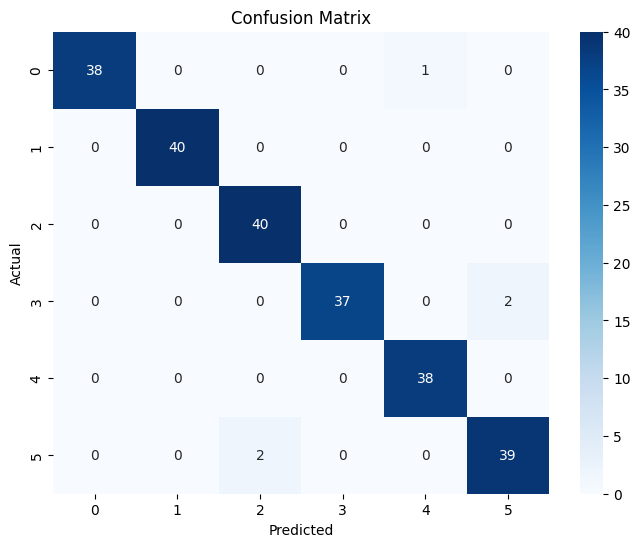

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       1.00      1.00      1.00        40
           2       0.95      1.00      0.98        40
           3       1.00      0.95      0.97        39
           4       0.97      1.00      0.99        38
           5       0.95      0.95      0.95        41

    accuracy                           0.98       237
   macro avg       0.98      0.98      0.98       237
weighted avg       0.98      0.98      0.98       237



In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC


# Load dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = "/kaggle/input/cotton-leaf-disease-dataset/train"
test_dir = "/kaggle/input/cotton-leaf-disease-dataset/test"

# Improved Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    zoom_range=0.3
)
train_generator = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=True)
test_generator = datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="sparse", shuffle=False)

# Feature Extraction with Two Models
def extract_features(generator, model, num_images):
    features, labels = [], []
    for images, lbls in generator:
        batch_features = model.predict(images)
        features.extend(batch_features)
        labels.extend(lbls)
        if len(features) >= num_images:
            break
    return np.array(features[:num_images]), np.array(labels[:num_images], dtype=int)

# Use an Ensemble of Feature Extractors
base_model1 = InceptionResNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))
base_model2 = EfficientNetB3(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))

feature_extractor1 = Model(inputs=base_model1.input, outputs=base_model1.output)
feature_extractor2 = Model(inputs=base_model2.input, outputs=base_model2.output)

# Extract features for train & test
X_train_features1, y_train_labels = extract_features(train_generator, feature_extractor1, train_generator.samples)
X_train_features2, _ = extract_features(train_generator, feature_extractor2, train_generator.samples)
X_test_features1, y_test_labels = extract_features(test_generator, feature_extractor1, 237)
X_test_features2, _ = extract_features(test_generator, feature_extractor2, 237)

# Concatenate Features from Both Extractors
X_train_features = np.concatenate([X_train_features1, X_train_features2], axis=1)
X_test_features = np.concatenate([X_test_features1, X_test_features2], axis=1)

# Apply SMOTE Only on Training Data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_features, y_train_labels)

# Split training data into train-validation
x_train, x_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)

# Focal Loss (to handle class imbalance)
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        # Ensure y_true and y_pred have the same shape
        y_true = K.cast(y_true, 'float32')  # Convert labels to float
        y_pred = K.clip(y_pred, 1e-8, 1.0 - 1e-8)  # Avoid log(0) issues

        # Compute focal loss
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        loss = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)

        return K.mean(loss)
    return loss


# Improve Meta-Heuristic Optimization
class GeneticAlgorithm:
    def __init__(self, population_size=20, generations=15):  # Increased size & depth
        self.population_size = population_size
        self.generations = generations
        self.population = [{'learning_rate': random.uniform(0.00005, 0.003),
                            'units': random.randint(128, 512),
                            'dropout': random.uniform(0.2, 0.5)} for _ in range(population_size)]

    def evaluate(self, params):
        model = Sequential([
            tf.keras.layers.Input(shape=(3072,)),  # Fix input layer
            Dense(int(params['units']), activation='relu'),
            BatchNormalization(),
            Dropout(params['dropout']),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(6, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                      loss=focal_loss(),  # Using Focal Loss
                      metrics=['accuracy'])
        history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0)
        return history.history.get('val_accuracy', [0.0])[-1]

    def optimize(self):
        for _ in range(self.generations):
            scores = [(self.evaluate(ind), ind) for ind in self.population]
            scores.sort(reverse=True, key=lambda x: x[0])
            self.population = [ind for _, ind in scores[:self.population_size // 2]]
        return self.population[0]

# Train Model with Best Hyperparameters
optimizer = GeneticAlgorithm(population_size=20, generations=15)
best_hyperparams = optimizer.optimize()

final_model = Sequential([
    tf.keras.layers.Input(shape=(3072,)),  # Fix input layer
    Dense(int(best_hyperparams['units']), activation='relu'),
    BatchNormalization(),
    Dropout(best_hyperparams['dropout']),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])
final_model.compile(
    optimizer=Adam(learning_rate=best_hyperparams['learning_rate']),
    loss=focal_loss(),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

history = final_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

# Evaluate on Test Data
y_pred = np.argmax(final_model.predict(X_test_features), axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))

In [3]:
train_precision = history.history.get('precision') or history.history.get('precision_1')
val_precision = history.history.get('val_precision') or history.history.get('val_precision_1')
train_recall = history.history.get('recall') or history.history.get('recall_1')
val_recall = history.history.get('val_recall') or history.history.get('val_recall_1')

train_f1 = [2 * (p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(train_precision, train_recall)]
val_f1 = [2 * (p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(val_precision, val_recall)]


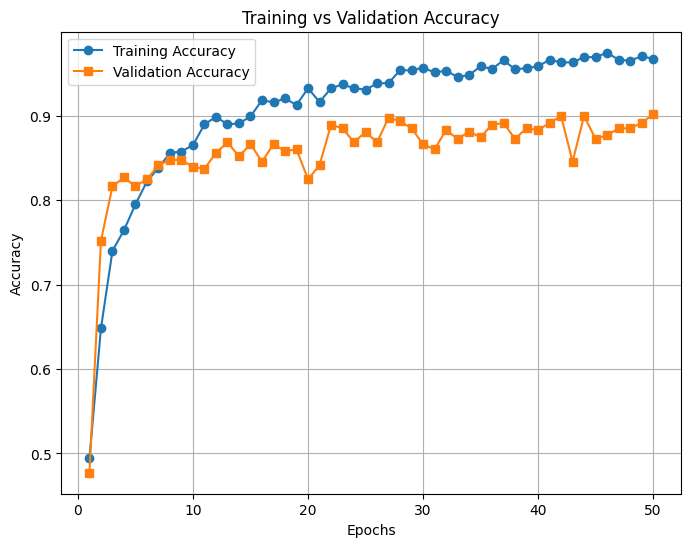

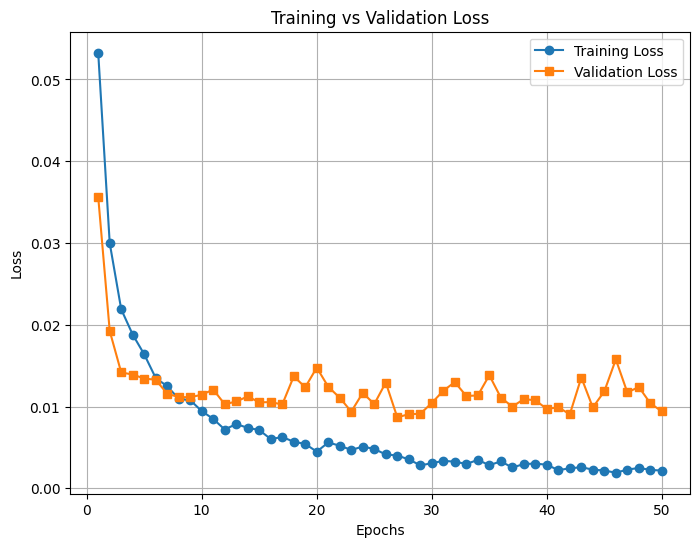

In [4]:
# Extract accuracy and loss from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Accuracy
epochs = range(1, len(train_accuracy) + 1)  # Define epoch range

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


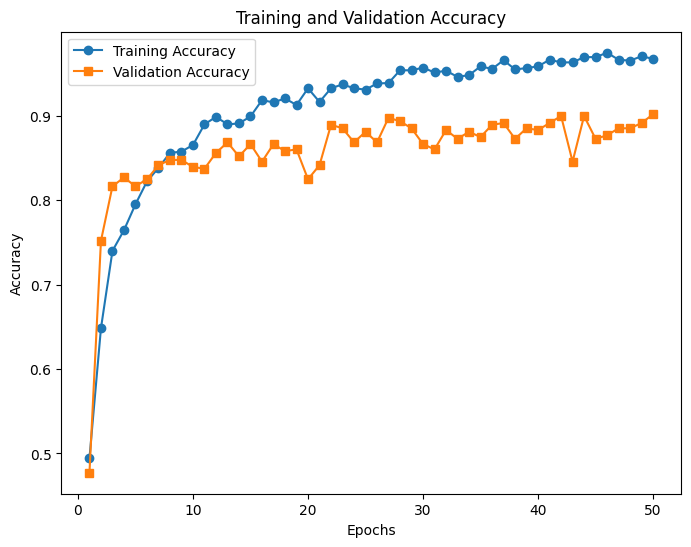

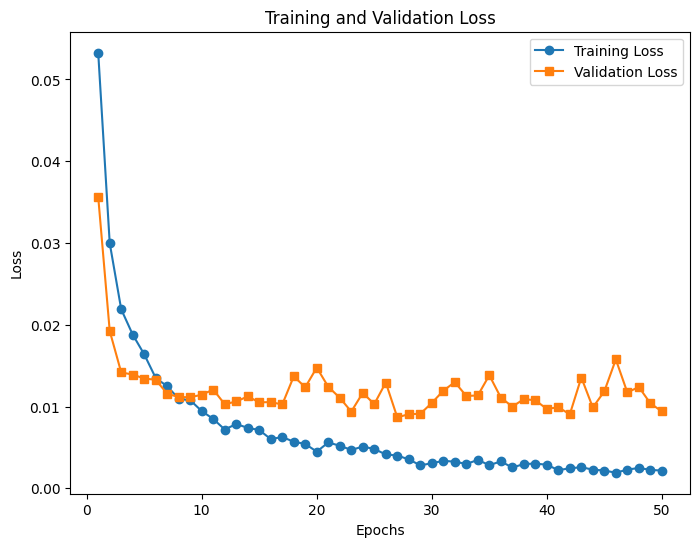

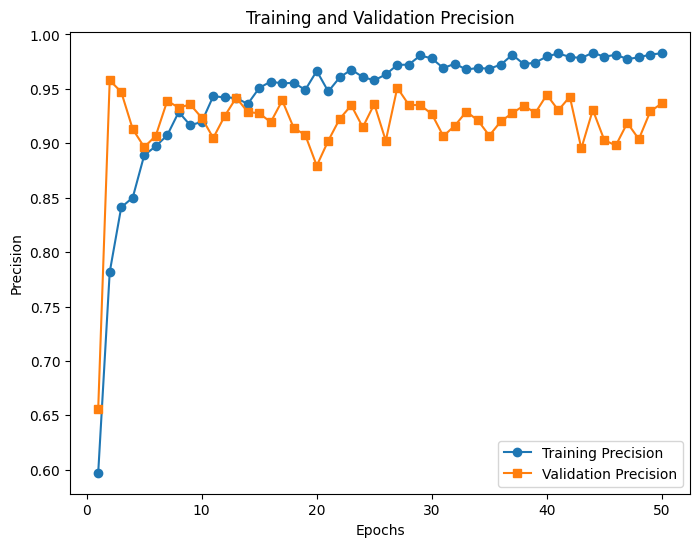

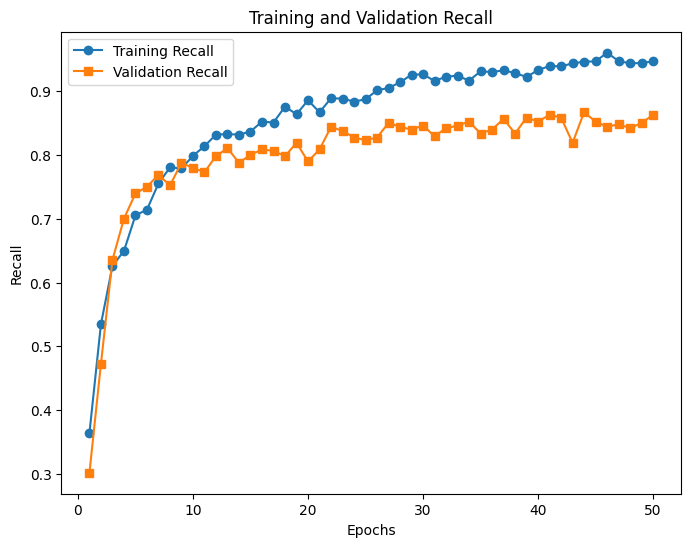

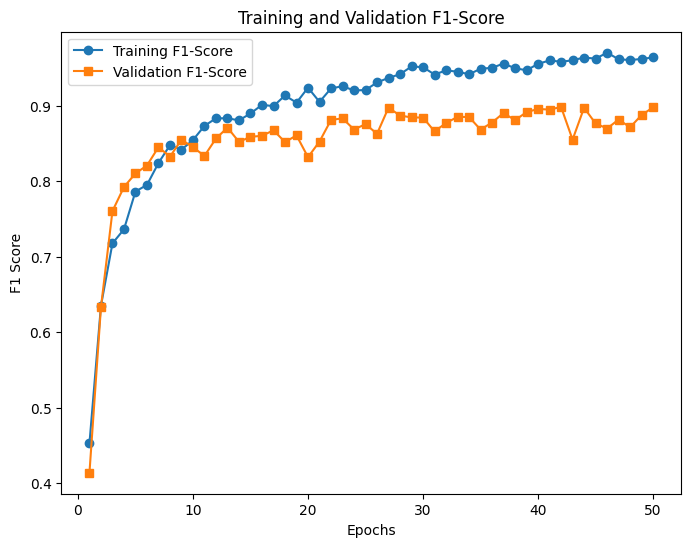

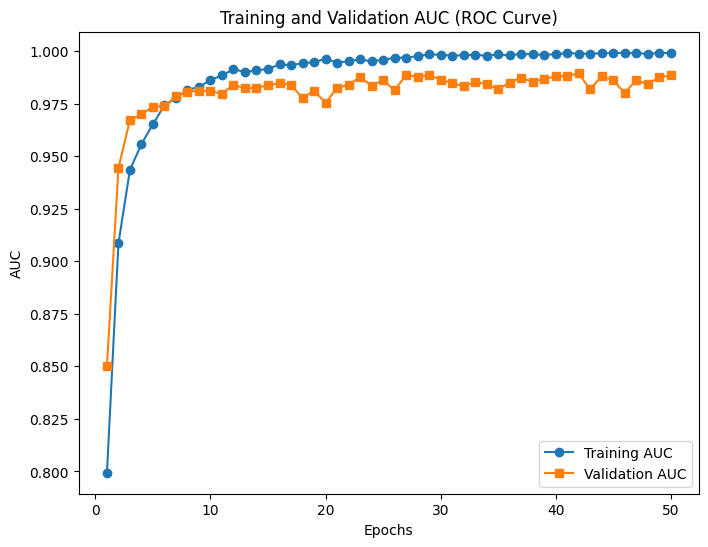

In [5]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_precision, label='Training Precision', marker='o')
plt.plot(epochs, val_precision, label='Validation Precision', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_recall, label='Training Recall', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_f1, label='Training F1-Score', marker='o')
plt.plot(epochs, val_f1, label='Validation F1-Score', marker='s')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1-Score')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['auc'], label='Training AUC', marker='o')
plt.plot(epochs, history.history['val_auc'], label='Validation AUC', marker='s')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training and Validation AUC (ROC Curve)')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


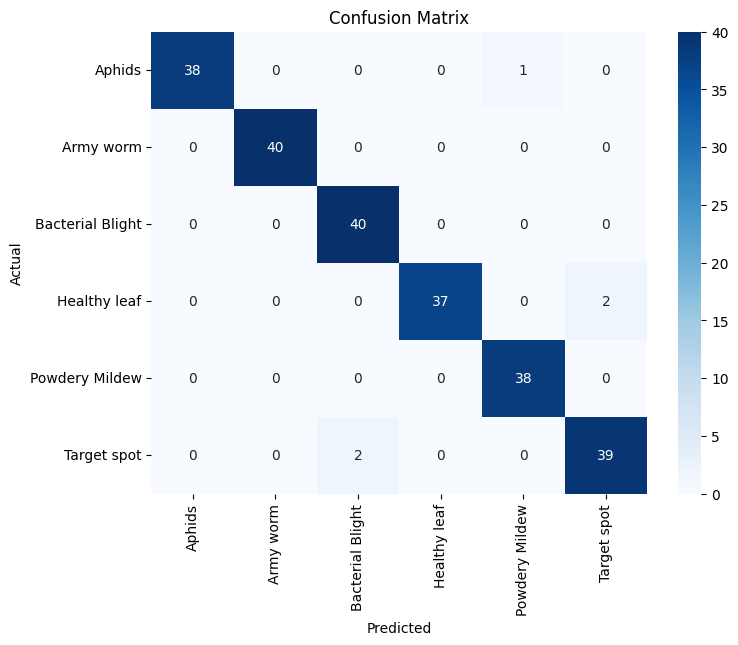

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class names
class_names = ["Aphids", "Army worm", "Bacterial Blight", "Healthy leaf", "Powdery Mildew", "Target spot"]

# Generate predictions
y_pred = np.argmax(final_model.predict(X_test_features), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Plot confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Print classification report with class names
print("Classification Report:")
print(classification_report(y_test_labels, y_pred, target_names=class_names))


Classification Report:
                  precision    recall  f1-score   support

          Aphids       1.00      0.97      0.99        39
       Army worm       1.00      1.00      1.00        40
Bacterial Blight       0.95      1.00      0.98        40
    Healthy leaf       1.00      0.95      0.97        39
  Powdery Mildew       0.97      1.00      0.99        38
     Target spot       0.95      0.95      0.95        41

        accuracy                           0.98       237
       macro avg       0.98      0.98      0.98       237
    weighted avg       0.98      0.98      0.98       237

